### SVM Model for SASB Data
Using the json file provided by SASB, I cleaned the data and built a SVM classification model to identify the data as labor relevant or not labor relevant. Grid search was used to optimize for model parameters and precision/recall curve is the outcome metrics. 

The next major steps are 
1. Look into the poorly classified data and see if there are any trends
2. appending our 10-k data and test it on the built model
3. refining the model to be a multiclassifier and further classify the documents into specific labor related issues

In [1]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import os

In [2]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from tqdm._tqdm_notebook import tqdm_notebook
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
import sys
sys.path.append("../..")
#from DFG_Text_Features.ipynb import *
#from E4525_ML import plots
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

/Users/Emily/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [3]:
tqdm_notebook.pandas()

In [4]:
# CHANGE PATH TO REFLECT JSON LOCATION 
path = "/Users/Emily/Desktop/dfg-humanrights/from-sasb"
os.chdir(path)

In [5]:
json = pd.read_json("di_hc_rel_train.json")
json

,company_ticker,disclosure_topic_id,excerpt,excerpt_id,industry_id,quality_assessment,relevance_assessment,source_document
0,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-147641,TR-AL,No Disclosure,No Disclosure,
1,AAL,TR-AL-310a,Earnings per share:\nShares used for computati...,2017-AAL-TR-AL-310a-147711,TR-AL,No Disclosure,No Disclosure,
2,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-148045,TR-AL,No Disclosure,No Disclosure,
3,AAL,TR-AL-310a,Approximate number of active full-time equival...,2017-AAL-TR-AL-310a-2483765,TR-AL,No Disclosure,No Disclosure,
4,AAL,TR-AL-310a,Employee bonus expense included costs related ...,2017-AAL-TR-AL-310a-2484043,TR-AL,No Disclosure,No Disclosure,
5,AAL,TR-AL-310a,Our 2017 mainline CASM excluding special items...,2017-AAL-TR-AL-310a-2484104,TR-AL,No Disclosure,No Disclosure,
6,AAL,TR-AL-310a,"Salaries, wages and benefits increased 8.5% pr...",2017-AAL-TR-AL-310a-2484240,TR-AL,Metrics,Relevant,
7,AAL,TR-AL-310a,"Salaries, wages and benefits increased 14.4% p...",2017-AAL-TR-AL-310a-2484280,TR-AL,Metrics,Relevant,
8,AAL,TR-AL-310a,Includes minimum pension contributions based o...,2017-AAL-TR-AL-310a-2484365,TR-AL,No Disclosure,No Disclosure,
9,AAL,TR-AL-310a,"During 2017, we contributed $286 million to ou...",2017-AAL-TR-AL-310a-2484735,TR-AL,No Disclosure,No Disclosure,


In [6]:
# CHANGE PATH TO REFLECT JSON LOCATION 
toplabel = pd.read_csv("disclosure_topic.csv")
toplabel.columns = map(str.lower, toplabel.columns)
toplabel.head()


,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension
0,CG-AA-250a,Management of Chemicals in Products,CG-AA,NaN
1,CG-AA-430a,Environmental Impacts in the Supply Chain,CG-AA,NaN
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN
3,CG-AA-440a,Raw Materials Sourcing,CG-AA,NaN
4,CG-AM-250a,Product Safety,CG-AM,NaN


In [7]:
# How many are related to labor?
labor_topics=toplabel[toplabel["disclosure_topic_name"].str.contains("labor", case = False) ]["disclosure_topic_name"].unique()
toplabel[toplabel['disclosure_topic_name'].isin(labor_topics)]

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN
21,CG-MR-310a,Labor Practices,CG-MR,NaN
25,CG-TS-430a,Labor Conditions in the Supply Chain,CG-TS,NaN
41,EM-CO-310a,Labor Relations,EM-CO,NaN
75,EM-MM-310a,Labor Relations,EM-MM,NaN
117,FB-FR-310a,Labor Practices,FB-FR,NaN
150,FB-RN-310a,Labor Practices,FB-RN,NaN
258,IF-WM-310a,Labor Practices,IF-WM,NaN
350,SV-HL-310a,Labor Practices,SV-HL,NaN
363,TC-ES-310a,Labor Practices,TC-ES,NaN


In [8]:
topic_id_list= toplabel[toplabel['disclosure_topic_name'].isin(labor_topics)]['disclosure_topic_id'].unique()
json[json['disclosure_topic_id'].isin(topic_id_list)]

,company_ticker,disclosure_topic_id,excerpt,excerpt_id,industry_id,quality_assessment,relevance_assessment,source_document
0,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-147641,TR-AL,No Disclosure,No Disclosure,
1,AAL,TR-AL-310a,Earnings per share:\nShares used for computati...,2017-AAL-TR-AL-310a-147711,TR-AL,No Disclosure,No Disclosure,
2,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-148045,TR-AL,No Disclosure,No Disclosure,
3,AAL,TR-AL-310a,Approximate number of active full-time equival...,2017-AAL-TR-AL-310a-2483765,TR-AL,No Disclosure,No Disclosure,
4,AAL,TR-AL-310a,Employee bonus expense included costs related ...,2017-AAL-TR-AL-310a-2484043,TR-AL,No Disclosure,No Disclosure,
5,AAL,TR-AL-310a,Our 2017 mainline CASM excluding special items...,2017-AAL-TR-AL-310a-2484104,TR-AL,No Disclosure,No Disclosure,
6,AAL,TR-AL-310a,"Salaries, wages and benefits increased 8.5% pr...",2017-AAL-TR-AL-310a-2484240,TR-AL,Metrics,Relevant,
7,AAL,TR-AL-310a,"Salaries, wages and benefits increased 14.4% p...",2017-AAL-TR-AL-310a-2484280,TR-AL,Metrics,Relevant,
8,AAL,TR-AL-310a,Includes minimum pension contributions based o...,2017-AAL-TR-AL-310a-2484365,TR-AL,No Disclosure,No Disclosure,
9,AAL,TR-AL-310a,"During 2017, we contributed $286 million to ou...",2017-AAL-TR-AL-310a-2484735,TR-AL,No Disclosure,No Disclosure,


In [9]:
topic_id_list

array(['CG-AA-430b', 'CG-MR-310a', 'CG-TS-430a', 'EM-CO-310a',
       'EM-MM-310a', 'FB-FR-310a', 'FB-RN-310a', 'IF-WM-310a',
       'SV-HL-310a', 'TC-ES-310a', 'TC-ES-320a', 'TR-AF-310a',
       'TR-AL-310a', 'TR-AU-310a', 'TR-CL-310a'], dtype=object)

In [10]:
# Create new label that flags labor only
toplabel["disclosure_islabor"] = toplabel["disclosure_topic_name"].str.contains("labor", case = False)
toplabel.head() 

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension,disclosure_islabor
0,CG-AA-250a,Management of Chemicals in Products,CG-AA,NaN,False
1,CG-AA-430a,Environmental Impacts in the Supply Chain,CG-AA,NaN,False
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN,True
3,CG-AA-440a,Raw Materials Sourcing,CG-AA,NaN,False
4,CG-AM-250a,Product Safety,CG-AM,NaN,False


In [11]:
toplabel[toplabel['disclosure_islabor'] ==True ]

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension,disclosure_islabor
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN,True
21,CG-MR-310a,Labor Practices,CG-MR,NaN,True
25,CG-TS-430a,Labor Conditions in the Supply Chain,CG-TS,NaN,True
41,EM-CO-310a,Labor Relations,EM-CO,NaN,True
75,EM-MM-310a,Labor Relations,EM-MM,NaN,True
117,FB-FR-310a,Labor Practices,FB-FR,NaN,True
150,FB-RN-310a,Labor Practices,FB-RN,NaN,True
258,IF-WM-310a,Labor Practices,IF-WM,NaN,True
350,SV-HL-310a,Labor Practices,SV-HL,NaN,True
363,TC-ES-310a,Labor Practices,TC-ES,NaN,True


### Preprocessing 

These methods stem, tokenize, remove stop words and punctuation, and return the cleaned text in the form of a new string (this is the necessary data structure for input into the SVM model-you can also return the cleaned text in the form of a list of words by changing my_tokenizer() method)

In [12]:
#import spacy
#from html import unescape

# create a spaCy tokenizer
#spacy.load('en')
#lemmatizer = spacy.lang.en.English()

def stem_tokenizer(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]

# remove html entities from docs and
# set everything to lowercase
def my_preprocessor(text):
    if (type(text) is not list):
        text=text.split('\n')
    text=" ".join(text).replace("\n"," ").replace('\u200b', '').replace('\n', '')
    return text

# tokenize the doc and lemmatize its tokens
def my_tokenizer(text):
    porter_stemmer = PorterStemmer()
    punctuation=list(string.punctuation)
    stop0=" ".join(stopwords.words("english")+punctuation)
    stop_words=set(stem_tokenizer(stop0))
    stem_list=stem_tokenizer(text)
    used_list=[token for token in stem_list if token not in stop_words]
    final_str=' '.join([str(elem) for elem in used_list]) 
    return final_str

def preprocess(filename):
    with open(filename, 'rb') as fh:
        doc = fh.read().decode("utf-8")
    text=my_preprocessor(doc)
    
    used_list=my_tokenizer(text)
    used_list=' '.join([str(elem) for elem in used_list]) 
    return used_list
    
# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [13]:
json['clean_text']=json['excerpt'].progress_apply(lambda x: my_tokenizer(x))

### SVM Model 
Create train/text split, encodes the data, then runs GridSearch to optimize parameters. 
The optimal parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [14]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm, metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score, auc, roc_curve
import matplotlib.pyplot as plt 



In [15]:
json['label']=np.where(json['disclosure_topic_id'].isin(topic_id_list),1,0)
#topic_id_list= toplabel[toplabel['disclosure_topic_name'].isin(labor_topics)]['disclosure_topic_id'].unique()


In [16]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(json['clean_text'],json['label'],test_size=0.3)

In [17]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [18]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(json['clean_text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [22]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels=['linear','rbf']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}
    
    grid_search = GridSearchCV(svm.SVC(), param_grid)
    grid_search.fit(Train_X_Tfidf,Train_Y)
    grid_search.best_params_
    return grid_search.best_params_

In [23]:
best_params=svc_param_selection(Train_X_Tfidf,Train_Y )

/Users/Emily/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
best_params

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

### Outcomes Analysis
1. ROC Curve: requires predictions of probabilitites, prioritizes accuracy the most
2. Precision-Recall Curve: requires actual label predictions, most ideal for this model because we care the most about precision and have an imbalanced dataset

In [19]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Test_Y))]
# fit a model

SVM = svm.SVC(C=10, kernel='rbf', degree=3, gamma=1,probability=True)
SVM.fit(Train_X_Tfidf,Train_Y)

#model = LogisticRegression(solver='lbfgs')
#model.fit(trainX, trainy)

# predict probabilities
lr_probs = SVM.predict_proba(Test_X_Tfidf)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
yhat = SVM.predict(Test_X_Tfidf)



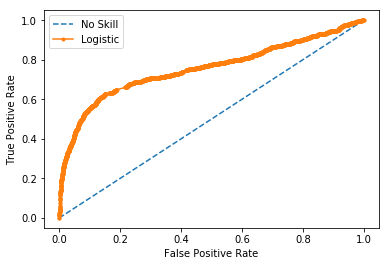

In [85]:
# calculate roc curves

# calculate scores
ns_auc = roc_auc_score(Test_Y, ns_probs)
lr_auc = roc_auc_score(Test_Y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Test_Y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Source for precision recall curve: 
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Logistic: fl=0.458 auc=0.569


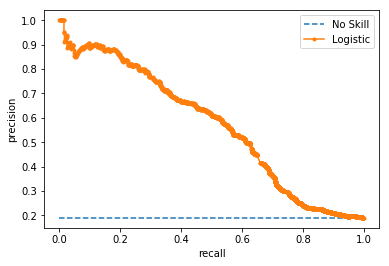

In [91]:
lr_precision, lr_recall, _=precision_recall_curve(Test_Y,lr_probs)
lr_f1, lr_auc=f1_score(Test_Y,yhat ), auc(lr_recall, lr_precision)
print('Logistic: fl=%.3f auc=%.3f' %(lr_f1, lr_auc))
#plot precision recall curves

no_skill=len(Test_Y[Test_Y==1])/len(Test_Y)
plt.plot([0,1],[no_skill, no_skill], linestyle='--',label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
#axis label

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check excerpts more closely
json["excerpt"].head()

# Are there any duplicates in text, in excerpt_id?
json.shape
json.drop_duplicates("excerpt").shape
json.drop_duplicates("excerpt_id").shape
# So, there are duplicates in text but not in excerpt_id

# What proportion are quality_assessment, relevance_assessment categories?
json["relevance_assessment"].groupby("relevance_assessment").agg("count")

# Are there any duplicates in text, in excerpt_id?

# If there is a disclosure topic id, then why  would the relevance_assessment be "no disclosure"?


0    Reclassifications out of AOCI for the years en...
1    Earnings per share:\nShares used for computati...
2    Reclassifications out of AOCI for the years en...
3    Approximate number of active full-time equival...
4    Employee bonus expense included costs related ...
Name: excerpt, dtype: object

(20626, 8)

(16749, 8)

(20626, 8)

KeyError: 'relevance_assessment'

In [16]:
# Merge, take tally of all disclosure topic occurrences
json = pd.merge(json, right = toplabel, 
               on = "disclosure_topic_id")
json.head()

# Figure out how many related to any disclosure
json["is_disclosure"] = json["relevance_assessment"]
# Figure out how many related to labor


,company_ticker,disclosure_topic_id,excerpt,excerpt_id,industry_id_x,quality_assessment,relevance_assessment,source_document,disclosure_topic_name,industry_id_y,sustainability_dimension
0,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-147641,TR-AL,No Disclosure,No Disclosure,,Labor Practices,TR-AL,NaN
1,AAL,TR-AL-310a,Earnings per share:\nShares used for computati...,2017-AAL-TR-AL-310a-147711,TR-AL,No Disclosure,No Disclosure,,Labor Practices,TR-AL,NaN
2,AAL,TR-AL-310a,Reclassifications out of AOCI for the years en...,2017-AAL-TR-AL-310a-148045,TR-AL,No Disclosure,No Disclosure,,Labor Practices,TR-AL,NaN
3,AAL,TR-AL-310a,Approximate number of active full-time equival...,2017-AAL-TR-AL-310a-2483765,TR-AL,No Disclosure,No Disclosure,,Labor Practices,TR-AL,NaN
4,AAL,TR-AL-310a,Employee bonus expense included costs related ...,2017-AAL-TR-AL-310a-2484043,TR-AL,No Disclosure,No Disclosure,,Labor Practices,TR-AL,NaN
